# Priority Experience Replay

Prereq: You should now know [Dueling DQN](http://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Dueling%20Deep-Q%20Learning/dueling_deep_q_learning.ipynb). Although what we are exploring today can be used for anything, we will keep going from the Dueling DQN Method for the implementation 

### Sampling is Everything
Another area to improve our model is how we sample our batches! In our replay buffer, we store our experiences and then when training our model, we randomly sample batches of data from it! The problem is, when we sample batches, we do it completely randomly with a uniform distribution. All memories are equally likely to be selected, but it makes sense that we would really want to only select samples that have more value to us to learn from. 

### Metaphor: Studying for an Exam

Lets say you are studying for an exam and it covers a few different topics such as Matrix Multiplications, Matrix Inverses and Matrix Derivatives. For the exam your teacher gave you a bunch of practice problems. You know already that doing Matrix Multiplication and Inverses are easy, its the derivatives that you struggle with. So, when picking problems to practice, would you sample more of the Derivatives to get more practice for it, or would you randomly solve problems? Of course not, you would put more practice into the thing that is harder!

### TD-Error Measure "Difficulty"

Remember, the goal of our neural network is to minimize the difference between the TD Target sampled from experience and our Predictions. This means our TD-Error is the absolute difference between the two (basically the magnitude of how wrong we are). We can store these TD Errors in our Replay Buffer and then sample things with higher error with more likelihood as this will make the Neural Network put more focus on cases that it struggles with!

### Setup For Priorities

Our priorities will be another cache in our Replay Buffer that we will store the TD Error. There are a few ways you can define these priorities, but the most common is:

$$\text{Priorities} = |\text{TD-ERROR}| + \epsilon$$

The $\epsilon$ is just a small constant we add onto our TD-Error to make sure nothing ever has 0 Priority. If our TD-Error is small, the neural network is already good at those cases, but still we dont want our model to forget stuff its already good at, so every so often it should still sample them, therefore a small priority

### Calculating the Probabilities

After calculating our priorities, we now have for every experience, a number representing how much of a challenge that sample was for our model. We want to simply sample those cases that were more challenging with higher likelihood. For shorthand lets let our priorities be $\delta_i$ for the $i^{th}$ experience 

Then our priorities vector (For N Memories) will be:

$$[\delta_0, \delta_1, \delta_2, \delta_3, ... \delta_{N-1}]$$

We can easily convert this to probabilities by doing:

$$P(i) = \frac{\delta_i}{\sum_{j=0}^{N-1}\delta_j}$$

This will convert our values to a probability distribution, but we can then add a prioritization constant. Basically, we want to interpolate somewhere between perfect probabilities (full priority like we have now) and no priority (uniform like we had before). To do this we can simply exponentiate with $\alpha$:

$$P(i) = \frac{\delta_i^\alpha}{\sum_{j=0}^{N-1}\delta_j^\alpha}$$

As $\alpha \rightarrow 0$, $P(i) \rightarrow \frac{1}{N}$ and is therefore Uniform

As $\alpha \rightarrow 1$, $P(i) \rightarrow \frac{\delta_i}{\sum_{j=0}^{N-1}\delta_j}$ and is therefore our original probabiltiies

Any $\alpha$ in between $0,1$ will interpolate between no and full priority!

### Importance Sampling

Unfortunately, this leads to a new problem, and that our sampling process is not representative of the distribution of the samples. When we do perfect random sampling, then we can assume that our batch is a good representative of the distribution of samples we are grabbing from. But now, our batch is biased towards samples with higher priority, therefore, we need to do something called Importance Sampling!

Importance Sampling is a Monte-Carlo method when we are trying to evaluate one distribution from a different one! For example, lets say we want to compute the Expectation of some distribution $A(x)$. Unfortunately, sampling directly from $A(x)$ can be very difficult or inefficient (like the posterior distribution in bayesian inference, or high dimensional distributions). So instead of sampling directly from $A(x)$, why not sample from some other distribution $B(x)$, and then adjust the resulst by weighting by the ratio of the distribution $\frac{A(x)}{B(x)}$

Lets say we wanted to find the $E_A[f(x)]$, under the function $A(x)$. We know this is impossible as we cannot just intergrate or sample over $A(x)$ directly. Therefore we go through our easier distribution $B(x)$ like the following:

$$E_A\left[f(x)\right] = \int f(x)A(x)dx = \int f(x) \frac{A(x)}{B(x)}q(x)dx = E_B\left[f(x)\frac{A(x)}{B(x)}\right]$$

So we need to make sure when we are sampling via our priorities, we adjust the weight of each sample, and this is pretty simple in our case:

$A(x)$ is our starting distribution, which is just uniform, therefore $\frac{1}{N}$

$B(x)$ is our new distribution (which comes from calculating the probabilities) therefore is just $P(i)$ for that sample

And so our weight for every sample will simply be:

$$w_i = \left(\frac{1}{N} \cdot \frac{1}{P(i)}\right) $$

The whole purpose of this is to adjust our loss. Things that are higher priority (with higher $P(i)$) are more likely to be selected, therefore we will weight them down in our loss so they have a proportionate effect on our final loss. But something else to keep in mind! At the start of training, we don't really care about this we just want the model to learn. But once the model starts getting better and only focuses on higher priority samples, we want to make sure it doesnt forget about how to do the easy stuff. Therefore a common trick is to anneal these weights like the following:

$$w_i = \left(\frac{1}{N} \cdot \frac{1}{P(i)}\right)^\beta $$

where $\beta$ is a constant term taht is started around 0.4 at the beginning (reducing the effects of the weights) but increased to 1 during training to put more emphasis on the weighting!

### One More Caveat

When we calculate our TD Error, that is for that current iteration of the model, but our model will continue to change, and therefore it can get better or worse at different states. This means that, technically, if we update our model, we need to pass **ALL** of our samples in the cache into our model again to get the new estimate for the priority.

The problem is, if your cache has Millions of samples, this would be computationally prohibitive. As a simplification, we only update the priorities of the sampled batch. This means for the samples we selected, we can compute how well or bad we are doing on them, and then update their priority accordingly so we are more or less likely to sample it again!


### Lets Implement It!

We need to update our TimeCapsule now so lets go ahead and do it, making all the changed described above!


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import Video

class TimeCapsulePER:

    """
    Simple Class to store and replace memories
    """
    
    def __init__(self, 
                 max_memories, 
                 num_state_features=8, 
                 per_alpha=0.6, 
                 per_beta=0.4,
                 per_beta_increment=1e-4,
                 per_eps=1e-5):

        self.max_memories = max_memories
        self.current_memories_counter = 0
        self.alpha = per_alpha
        self.beta = per_beta
        self.beta_increment = per_beta_increment
        self.eps = per_eps

        self.state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.action_memory = torch.zeros((self.max_memories, ), dtype=torch.long)
        self.reward_memory = torch.zeros((self.max_memories, ), dtype=torch.float32)
        self.terminal_memory = torch.zeros((self.max_memories, ), dtype=torch.bool)

        ###############################
        ### ADD IN PRIORITIES CACHE ###
        self.priorities = torch.zeros((self.max_memories, ), dtype=torch.float32)
        ###############################

    def add_memory(self, state, next_state, action, reward, terminal, td_error):

        idx = self.current_memories_counter % self.max_memories

        self.state_memory[idx] = torch.tensor(state, dtype=self.state_memory.dtype)
        
        self.next_state_memory[idx] = torch.tensor(next_state, dtype=self.next_state_memory.dtype)
        self.action_memory[idx] = torch.tensor(action, dtype=self.action_memory.dtype)
        self.reward_memory[idx] = torch.tensor(reward, dtype=self.reward_memory.dtype)
        self.terminal_memory[idx] = torch.tensor(terminal, dtype=self.terminal_memory.dtype)

        ################################################
        ### ADD PRIORITIES (ABSOLUTE TD ERROR + eps) ###
        self.priorities[idx] = torch.tensor(abs(td_error) + self.eps) ** self.alpha
        ################################################
        
        self.current_memories_counter += 1

    def anneal_beta(self):

        #############################
        ### ADD IN BETA ANNEALING ###
        self.beta = min(1.0, self.beta + self.beta_increment)
        #############################
        
    def access_memories(self, batch_size, device="cpu"):

        total_memories = min(self.current_memories_counter, self.max_memories) 

        if total_memories < batch_size:
            return None

        #########################################
        ### Get Probabilities from Priorities ###
        priorities = self.priorities[:total_memories]
        probabilities = priorities / priorities.sum()

        ### Use Distribution to Sample ###
        rand_sample_idx = torch.multinomial(probabilities, num_samples=batch_size, replacement=False).to(dtype=torch.long)

        ### Bias Correction (Importance Sampling) ###
        weights = (total_memories * probabilities[rand_sample_idx]) ** (-self.beta)
        weights = weights / weights.max()
        
        ### Sample those indexes and return ###
        batch = {"states": self.state_memory[rand_sample_idx].to(device),
                 "next_states": self.next_state_memory[rand_sample_idx].to(device),
                 "actions": self.action_memory[rand_sample_idx].to(device),
                 "rewards": self.reward_memory[rand_sample_idx].to(device),
                 "terminal": self.terminal_memory[rand_sample_idx].to(device),
                 "indices": rand_sample_idx, 
                 "weights": weights}

        return batch

### Dueling DQN Model

Nothing changes in the model! Ee will just use our Dueling DQN from before!

In [2]:
class DuelingDQN(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(DuelingDQN, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features,hidden_features)

        self.value = nn.Linear(hidden_features, 1)
        self.advantage = nn.Linear(hidden_features, num_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        ###############################################
        ### COMPUTE VALUE/ADVANTAGE and Mean Center ###
        value = self.value(x)
        advantage = self.advantage(x)

        ### Average the Advantage For Each Sample Across the Actions ###
        advantage_mean = advantage.mean(dim=-1, keepdim=True)

        ### Mean Center the Advantage ###
        advantage = advantage - advantage_mean

        ### Compute Q Values ###
        Q = value + advantage 
        ###############################################
        
        return Q

### Update our Agent

A couple of changes are now made to our Agent. 

1) Make sure to use the new Timecapsule
2) In our MSE loss dont reduce by mean, we need to per sample loss so we can multiply by our Importance Sampling Weights
3) Compute TD Error and update our Timecapsule Priorities for the indices of the current batch
4) Multiply our per sample loss by its Importance Sampling weight
5) Anneal Beta

In [3]:
class Agent:
    def __init__(self,
                 max_memories=100_000,
                 discount_factor=0.99, 
                 learning_rate=0.001,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128,
                 epsilon=1.0, 
                 epsilon_decay=0.001, 
                 min_epsilon=0.05,
                 per_alpha=0.6, 
                 per_beta=0.4,
                 per_beta_increment=1e-4,
                 per_eps=1e-5,
                 device="cpu"):

        self.max_memories = max_memories
        self.discount_factor = discount_factor 
        self.learning_rate = learning_rate
        self.input_state_features = input_state_features
        self.num_actions = num_actions
        self.action_space = np.arange(self.num_actions)
        self.hidden_features = hidden_features
        self.epsilon = epsilon 
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon 
        self.device = device

        self.DQN = DuelingDQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT = DuelingDQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())
        self.DQN_NEXT.eval()
        
        self.optimizer = optim.Adam(self.DQN.parameters(), lr=self.learning_rate)

        ####################################################################
        ### WE DONT WANT TO AVG OUR LOSS UNTIL WE MULTIPLY BY IS WEIGHTS ###
        self.loss_fn = nn.MSELoss(reduction="none")
        
        ### UPDATE OUR TIMECAPSULE ###
        self.timecapsule = TimeCapsulePER(self.max_memories, self.input_state_features)
        ####################################################################

    def select_action(self, state):


        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device)
            
        if state.dim() == 1:
            state = state.unsqueeze(0)
            
        assert state.shape[-1] == self.input_state_features, f"Passing {state.shape[-1]} features, expect {self.input_state_features}"
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            self.DQN.eval()
            with torch.no_grad():
                Q_s_a = self.DQN(state)
            action = torch.argmax(Q_s_a).item()
            self.DQN.train()

        return action

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def inference(self, state, device="cpu"):

        self.DQN = self.DQN.to(device)
        self.DQN.eval()
        
        with torch.no_grad():
            Q_s_a = self.DQN(state.to(device))
            
        return torch.argmax(Q_s_a).item()
        
    def update_target_network(self):
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())

    def train_step(self, batch_size):

        batch = self.timecapsule.access_memories(batch_size, self.device)
        
        if batch is None:
            return None

        self.DQN.train()
        q_estimate = self.DQN(batch["states"])
        q_estimate = torch.gather(q_estimate, index=batch["actions"].unsqueeze(-1), dim=-1).squeeze(-1) 

        with torch.no_grad():

            next_q_values = self.DQN(batch["next_states"])
            next_actions = torch.argmax(next_q_values, dim=-1, keepdim=True)
            next_q_values_target = self.DQN_NEXT(batch["next_states"])
            max_q_next_estimate = next_q_values_target.gather(dim=-1, index=next_actions).squeeze(-1)

        td_target = batch["rewards"] + self.discount_factor * max_q_next_estimate * (~batch["terminal"])

        ########################
        ### COMPUTE TD ERROR ###
        td_error = td_target - q_estimate 

        ### COMPUTE SQUARE ERROR BTWN TARGET AND ESTIMATE ###
        loss = self.loss_fn(td_target, q_estimate)

        ### MULTIPLY PER SAMPLE LOSS BY IS WEIGHTS ###
        loss = batch["weights"].to(loss.device) * loss

        ### AVERAGE UP LOSSES ACROSS BATCH ###
        loss = loss.mean()

        ### UPDATE PRIORITIES FOR THIS BATCH ###
        updated_priorities = td_error.detach().cpu().abs()
        self.timecapsule.priorities[batch["indices"]] = (updated_priorities + self.timecapsule.eps) ** self.timecapsule.alpha

        ### UPDATE BETA ###
        self.timecapsule.anneal_beta()
        ########################
            
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.DQN.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.update_epsilon()


### Update The Trainer

One question you may have is, when we add a new sample to our Cache, what is its TD Error? There are two ways you can do this:

1) **SLOW**: Before adding to cache, inference the current model and get its TD Error and use that value 
2) **FAST**: Just use the Max TD Error in your priorities (or just 1.0). If we give new samples a high priority, it will be sampled anyway with a high likelihood into our batch, and then will get its updated, more realistic, TD Error at that stage (FAST)

In [4]:
def trainer(env, 
            num_games=500,
            update_target_freq=5,
            min_reward=200, 
            game_tolerance=5,
            max_memories=100_000,
            discount_factor=0.99, 
            learning_rate=0.001,
            batch_size=64,
            input_state_features=8, 
            num_actions=4,
            hidden_features=128,
            epsilon=1.0, 
            epsilon_decay=0.999, 
            min_epsilon=0.05,
            log_freq=5, 
            running_avg_steps=25,
            per_alpha=0.6, 
            per_beta=0.4,
            per_beta_increment=1e-4,
            per_eps=1e-5,
            device="cpu"):

    agent = Agent(max_memories=max_memories,
                  discount_factor=discount_factor, 
                  learning_rate=learning_rate,
                  input_state_features=input_state_features, 
                  num_actions=num_actions,
                  hidden_features=hidden_features,
                  epsilon=epsilon, 
                  epsilon_decay=epsilon_decay, 
                  min_epsilon=min_epsilon,
                  per_alpha=per_alpha, 
                  per_beta=per_beta,
                  per_beta_increment=per_beta_increment,
                  per_eps=per_eps,
                  device=device)

    ending_tol = 0

    log = {"scores": [], 
           "running_avg_scores": []}

    for i in range(num_games):
        
        score = 0
        step = 0
        state, _ = env.reset()
        done = False

        while not done:

            action = agent.select_action(state)
            next_state, reward, terminal, truncated, _= env.step(action)
            done = terminal or truncated

            score += reward

            ######################################################################################################
            ### WHEN WE ADD IN A NEW EXPERIENCE GIVE IT MAX PRIORITY, WHEN SAMPLED ITLL GET UPDATED ON ITS OWN ###
            td_error = agent.timecapsule.priorities.max().item() if agent.timecapsule.current_memories_counter > 0 else 1.0
            ######################################################################################################
            
            agent.timecapsule.add_memory(state, next_state, action, reward, done, td_error)
            agent.train_step(batch_size)

            if step % update_target_freq == 0:
                agent.update_target_network()

            step += 1
            state = next_state

        log["scores"].append(score)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)
        
        if i % log_freq == 0:
            print(f"Game #: {i} | Score: {score} | Moving Avg Scores: {running_avg_score} | Epsilon: {agent.epsilon}")
    
        if score >= min_reward:
            ending_tol += 1

            if ending_tol == game_tolerance:
                break
        else:
            ending_tol = 0
            
    print("Completed Training")
    return agent, log

device = "cuda" if torch.cuda.is_available() else "cpu"
env = gym.make("LunarLander-v3", render_mode="rgb_array")
agent_per, log_per = trainer(env, device=device)

Game #: 0 | Score: -164.03972135185074 | Moving Avg Scores: -164.03972135185074 | Epsilon: 0.9626946373158061
Game #: 5 | Score: -367.0868825645005 | Moving Avg Scores: -304.8956809561328 | Epsilon: 0.6027497547577038
Game #: 10 | Score: -157.76577306564883 | Moving Avg Scores: -238.10478351288376 | Epsilon: 0.27785929486848676
Game #: 15 | Score: -105.71124716753044 | Moving Avg Scores: -223.72481355119385 | Epsilon: 0.05
Game #: 20 | Score: -167.71826913676733 | Moving Avg Scores: -207.638385301596 | Epsilon: 0.05
Game #: 25 | Score: -312.0963048447685 | Moving Avg Scores: -193.28303362665258 | Epsilon: 0.05
Game #: 30 | Score: -17.25540025535877 | Moving Avg Scores: -142.78897409909882 | Epsilon: 0.05
Game #: 35 | Score: -116.4821719218004 | Moving Avg Scores: -127.09532776911095 | Epsilon: 0.05
Game #: 40 | Score: -161.26323257840752 | Moving Avg Scores: -114.20007029046435 | Epsilon: 0.05
Game #: 45 | Score: -16.50098908357623 | Moving Avg Scores: -105.38735950119055 | Epsilon: 0.

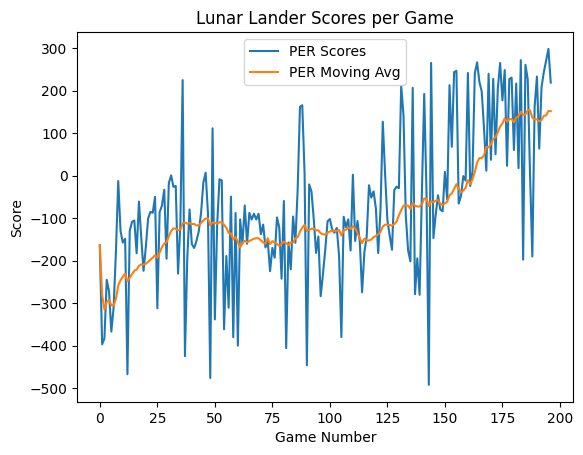

In [5]:
plt.plot(log_per["scores"], label="PER Scores")
plt.plot(log_per["running_avg_scores"], label="PER Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()